#### using the synthetic data from Misha. Quick validating of Unet

In [121]:
!pip install mrcfile

In [122]:
# data loading
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'

In [123]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

In [124]:
DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
data_ids = next(os.walk(DATA_PATH))[1]

In [126]:
import os
import pandas as pd
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc':#目录下包含.mrc的文件
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  7.30it/s]

tomo1_focalseries.mrc
tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_groundtruth.mrc


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]

tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


uint8


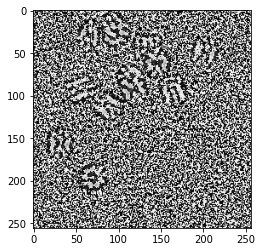

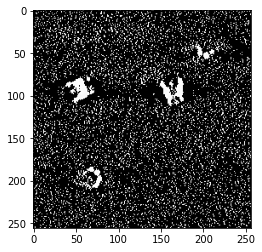

In [127]:
# sanity check for the data
import random
testF = focal[0]
testF.shape

testIm = testF[random.randint(0, testF.shape[0]),...]
print(testF.dtype)
plt.figure('focal');plt.imshow(testIm, cmap='gray')

testGT = GT[0]
testGT.shape

testIm = testGT[random.randint(0,testGT.shape[0]),...]
plt.figure();plt.imshow(testIm, cmap='gray')

In [171]:
# select the firt two (focal+ GT) as training, third as testing
import torchio as tio
from patchify import patchify, unpatchify

train_raw = focal[0];train = train_raw[...,np.newaxis].transpose((3,1,2,0)); train_label = GT[0];label = train_label[...,np.newaxis]
print(train_raw.shape)
# padding into the same size
trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0))
print(train_padd.shape);print(label.shape)

(101, 256, 256)
(256, 256, 256, 1)
(256, 256, 256, 1)


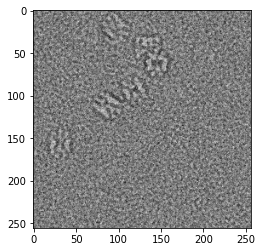

In [180]:
# sanity check
test = train_padd[77,...]
plt.imshow(test,cmap='gray')

In [182]:
# build the model with keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [183]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  # don't use sigmoid, direct output the dstribution

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# print(datanames)
# print(type(temp))
# print(len(focal))
# print(len(GT))
# print(type(test[0]))
# print(test[1].shape)
# print(test[2].shape)
# print(len(test))
